Import necessary packages

In [1]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# 1. Explore the Dataset

A glance at the dataset

In [2]:
data_raw=pd.read_csv("data_raw.csv", parse_dates=['week'])
data_raw

,week,sku,weekly_sales,feat_main_page,color,price,vendor,functionality
0,2016-10-31,1,135,True,black,10.16,6,06.Mobile phone accessories
1,2016-11-07,1,102,True,black,9.86,6,06.Mobile phone accessories
2,2016-11-14,1,110,True,black,10.24,6,06.Mobile phone accessories
3,2016-11-21,1,127,True,black,8.27,6,06.Mobile phone accessories
4,2016-11-28,1,84,True,black,8.83,6,06.Mobile phone accessories
...,...,...,...,...,...,...,...,...
4395,2018-08-27,44,20,False,black,53.99,6,09.Smartphone stands
4396,2018-09-03,44,14,False,NaN,52.99,6,09.Smartphone stands
4397,2018-09-10,44,22,True,black,44.99,6,09.Smartphone stands
4398,2018-09-17,44,28,True,NaN,42.99,6,09.Smartphone stands


In [3]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   week            4400 non-null   datetime64[ns]
 1   sku             4400 non-null   int64         
 2   weekly_sales    4400 non-null   int64         
 3   feat_main_page  4400 non-null   bool          
 4   color           4390 non-null   object        
 5   price           4400 non-null   float64       
 6   vendor          4400 non-null   int64         
 7   functionality   4400 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 245.0+ KB


There are 10 missing values in the color column

A rough statistical view for the data

In [4]:
data_raw.describe()

,sku,weekly_sales,price,vendor
count,4400.000000,4400.000000,4400.000000,4400.000000
mean,22.500000,83.054773,44.432709,6.909091
std,12.699868,288.000205,42.500295,2.503175
min,1.000000,0.000000,2.390000,1.000000
25%,11.750000,11.000000,15.680000,6.000000
50%,22.500000,25.000000,27.550000,6.500000
75%,33.250000,70.000000,54.990000,9.000000
max,44.000000,7512.000000,227.720000,10.000000


There are big gaps between mean and max for weekly_sales and price, it suggests that there are some outliers

A line chart for SKU 11

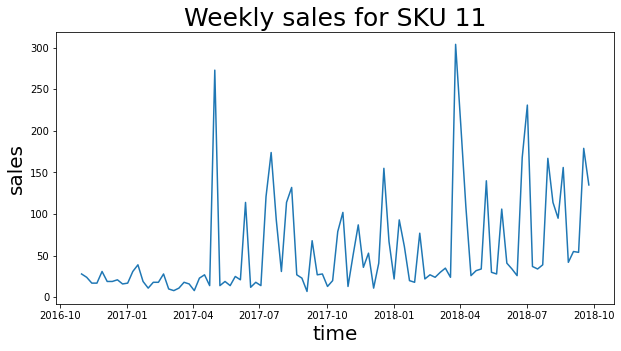

In [5]:
plt.figure(figsize=(10,5))
plt.plot(data_raw[data_raw['sku']==11]['week'],data_raw[data_raw['sku']==11]['weekly_sales'])
plt.ylabel('sales', fontsize=20)
plt.xlabel('time', fontsize=20)
plt.title("Weekly sales for SKU 11", fontsize=25)
plt.show()

#2. Data Processing
##2.1 Missing Data

In [6]:
data_raw[data_raw.color.isna()]

,week,sku,weekly_sales,feat_main_page,color,price,vendor,functionality
802,2016-11-14,9,54,True,NaN,139.44,9,11.Fitness trackers
803,2016-11-21,9,71,True,NaN,141.16,9,11.Fitness trackers
4133,2017-06-19,42,4,False,NaN,27.33,10,09.Smartphone stands
4196,2018-09-03,42,8,False,NaN,42.99,10,09.Smartphone stands
4197,2018-09-10,42,14,True,NaN,42.99,10,09.Smartphone stands
4200,2016-10-31,43,5,True,NaN,109.99,9,11.Fitness trackers
4314,2017-02-06,44,5,False,NaN,53.99,6,09.Smartphone stands
4391,2018-07-30,44,34,True,NaN,41.99,6,09.Smartphone stands
4396,2018-09-03,44,14,False,NaN,52.99,6,09.Smartphone stands
4398,2018-09-17,44,28,True,NaN,42.99,6,09.Smartphone stands


Filling method: Use the color sold in the next week or the previous week for the same sku to fill for the missing values. This method assumes that the color for each sku in a near period of time is the same

In [7]:
for i in data_raw[data_raw.color.isna()].index:
    if data_raw.at[i, 'sku'] == data_raw.at[i-1, 'sku']:
        data_raw.at[i, 'color'] = data_raw.at[i-1, 'color']
        print("week: {}, sku: {}, color: {}".format(i, data_raw.at[i, 'sku'],data_raw.at[i, 'color']))
    else:
        if data_raw.at[i, 'sku'] == data_raw.at[i+1, 'sku']:
            data_raw.at[i, 'color'] = data_raw.at[i+1, 'color']
            print("week: {}, sku: {}, color: {}".format(i, data_raw.at[i, 'sku'],data_raw.at[i, 'color']))

week: 802, sku: 9, color: black
week: 803, sku: 9, color: black
week: 4133, sku: 42, color: black
week: 4196, sku: 42, color: black
week: 4197, sku: 42, color: black
week: 4200, sku: 43, color: gold
week: 4314, sku: 44, color: black
week: 4391, sku: 44, color: black
week: 4396, sku: 44, color: black
week: 4398, sku: 44, color: black


## 2.2 Outlier Data

Use quantile with the low_cutoff and high_cutoff to identify the outliers. The cutoff values can be customized

In [8]:
def outliers_quantile(data,features,low_cutoff=0.00000001,high_cutoff=0.99999999):
    for f in features:
        data['outlier_'+f] = data.groupby('sku')[f].transform(
            lambda x:(x<(x.quantile(low_cutoff))) | (x>(x.quantile(high_cutoff)))
            )
    return data
data_1 = outliers_quantile(data_raw,['weekly_sales','price'])
data_1[data_1.outlier_weekly_sales]

,week,sku,weekly_sales,feat_main_page,color,price,vendor,functionality,outlier_weekly_sales,outlier_price
9,2017-01-02,1,154,True,black,9.19,6,06.Mobile phone accessories,True,False
171,2018-03-12,2,52,False,blue,63.99,1,07.Headphones,True,False
202,2016-11-14,3,38,False,purple,73.02,1,07.Headphones,True,False
252,2017-10-30,3,2,False,purple,109.99,1,07.Headphones,True,False
300,2016-10-31,4,28,False,red,13.20,6,06.Mobile phone accessories,True,False
...,...,...,...,...,...,...,...,...,...,...
4044,2017-09-04,41,8,False,black,15.84,5,09.Smartphone stands,True,False
4137,2017-07-17,42,23,True,black,31.99,10,09.Smartphone stands,True,False
4268,2018-02-19,43,31,True,gold,119.99,9,11.Fitness trackers,True,False
4293,2018-08-13,43,0,True,gold,162.99,9,11.Fitness trackers,True,False


In [9]:
data_1[data_1.outlier_price]

,week,sku,weekly_sales,feat_main_page,color,price,vendor,functionality,outlier_weekly_sales,outlier_price
3,2016-11-21,1,127,True,black,8.27,6,06.Mobile phone accessories,False,True
116,2017-02-20,2,2,False,blue,30.99,1,07.Headphones,False,True
123,2017-04-10,2,6,False,blue,75.99,1,07.Headphones,False,True
216,2017-02-20,3,9,False,purple,54.99,1,07.Headphones,False,True
284,2018-06-11,3,20,False,purple,111.19,1,07.Headphones,False,True
...,...,...,...,...,...,...,...,...,...,...
4132,2017-06-12,42,3,False,black,87.98,10,09.Smartphone stands,False,True
4136,2017-07-10,42,8,False,black,25.58,10,09.Smartphone stands,False,True
4238,2017-07-24,43,7,False,gold,74.99,9,11.Fitness trackers,False,True
4310,2017-01-09,44,10,True,black,30.60,6,09.Smartphone stands,False,True


In [10]:
data_1.to_csv('data_processed.csv',index=False)

#3 Time Series Model
Since this is time series data, I consider either using ARIMA or SARIMA model.
##3.1 Assessing Seasonality

In [11]:
data = pd.read_csv('data_processed.csv', parse_dates=['week'], index_col='week')

In [12]:
sku = {}
for i in range(1,45):
    sku[i] = pd.DataFrame(data[data['sku']==i]['weekly_sales'],columns = ['weekly_sales'])

Remove the trend to see the seasonal pattern more obviously

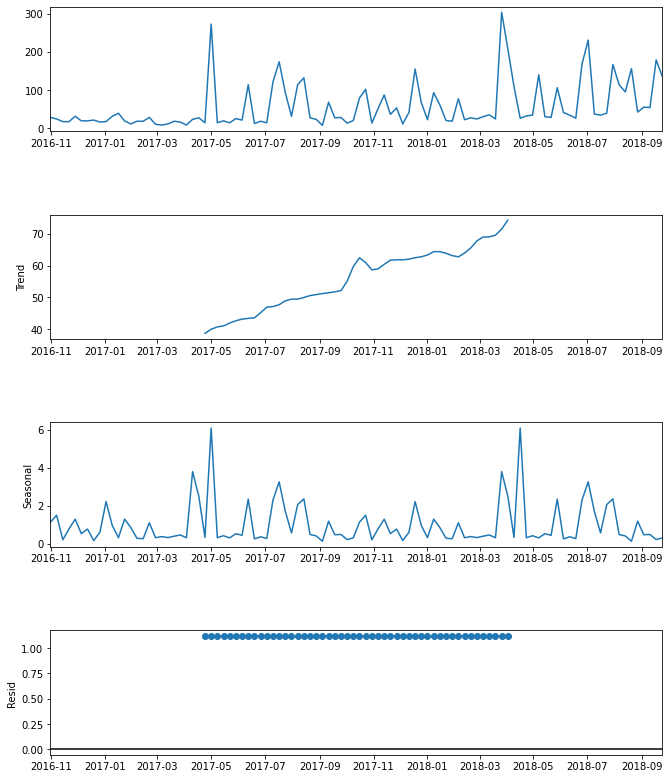

In [13]:
result = seasonal_decompose(sku[11], model='multiplicative',period=50)
fig = result.plot()
fig.set_size_inches(10, 12)

Looking at the seasonal chart, it suggests that there is a yearly seasonal cycle, so I choice SARIMA model

##3.2 Assessing Stationary

In order to apply SARIMA model, we need to assess the stationary assumption of the data.
I use Augmented Dickey Fuller test ( ADF Test), a common statistical test used to test whether a given Time series is stationary or not. 

In [14]:
def adfuller_test(sku,i):
    print("SKU {}".format(i))
    x = sku[i]['weekly_sales']
    result = adfuller(x)
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [15]:
for i in range(1,45):
    adfuller_test(sku,i)

SKU 1
ADF Test Statistic : -4.4726704549629215
p-value : 0.00022025012134457673
Data is stationary
SKU 2
ADF Test Statistic : -3.7106808532609383
p-value : 0.003965402173771292
Data is stationary
SKU 3
ADF Test Statistic : -2.217787735599355
p-value : 0.19985299102137627
Data is non-stationary 
SKU 4
ADF Test Statistic : -2.200113698769432
p-value : 0.20620419334657386
Data is non-stationary 
SKU 5
ADF Test Statistic : -3.4986751121526787
p-value : 0.008021185253305727
Data is stationary
SKU 6
ADF Test Statistic : -3.080160365968314
p-value : 0.028056676409990815
Data is stationary
SKU 7
ADF Test Statistic : -0.04998285179091249
p-value : 0.9541981193002773
Data is non-stationary 
SKU 8
ADF Test Statistic : -3.3463691565619516
p-value : 0.012928797897232457
Data is stationary
SKU 9
ADF Test Statistic : -2.8359716321970807
p-value : 0.053316345819100636
Data is non-stationary 
SKU 10
ADF Test Statistic : 0.9783791752127873
p-value : 0.9940325036106605
Data is non-stationary 
SKU 11
ADF 

Some SKUs are stationary, some are not. So we will set d from 0 to 2.

##3.3 Set-up parameters

To identify the best parameters, I use Akaike information criterion (AIC). It uses grid search and AIC index to find the best model for the data

In [16]:
train_data, test_data = {}, {}
for i in range(1,45):
    train_data[i], test_data[i] = sku[i][0:(len(sku[i])-12)], sku[i][(len(sku[i])-12):]

In [17]:
model_sarima = {}
from tqdm import tqdm
for i in tqdm(range(1,45)):
    model_sarima[i] = pm.auto_arima(train_data[i].weekly_sales, test='adf',
                            m=50, d=None,max_d=2,
                            seasonal=True, trace=False, error_action='ignore',  
                            suppress_warnings=True, stepwise=True)

 14%|█▎        | 6/44 [01:31<08:00, 12.64s/it]/usr/local/lib/python3.8/dist-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (38) is shorter than m (50). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "
 41%|████      | 18/44 [04:24<04:23, 10.13s/it]/usr/local/lib/python3.8/dist-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (38) is shorter than m (50). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "
 43%|████▎     | 19/44 [06:06<15:47, 37.90s/it]/usr/local/lib/python3.8/dist-packages/pmdarima/arima/utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (38) is shorter than m (50). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "
 73%|███████▎  | 32/44 [13:57<03:49, 19.09s/

#4. Prediction & Monitoring
##4.1 Prediction

In [18]:
n_pred_period = 4*3 # predict for 3 months look ahead

In [19]:
predict, confint, predict_ser = {}, {}, {}
for i in range(1,45):
    predict[i], confint[i] = model_sarima[i].predict(n_periods=n_pred_period, return_conf_int=True)
    predict_ser[i] = pd.DataFrame(predict[i])

Save the data

In [33]:
import pickle
pickle.dump(sku, open('sku.p', 'wb'))
pickle.dump(train_data, open('train_data.p', 'wb'))
pickle.dump(test_data, open('test_data.p', 'wb'))
pickle.dump(predict_ser, open('predict_ser.p', 'wb'))
pickle.dump(confint, open('confint.p', 'wb'))

Load the data

In [34]:
import pickle
sku = pickle.load(open('sku.p', 'rb'))
train_data = pickle.load(open('train_data.p', 'rb'))
test_data = pickle.load(open('test_data.p', 'rb'))
predict_ser = pickle.load(open('predict_ser.p', 'rb'))
confint = pickle.load(open('confint.p', 'rb'))

In [20]:
def plot_sku(sku,i):
    plt.figure(figsize=(16, 6))
    plt.plot(sku[i][:len(train_data[i])+1],color='chocolate',
             marker='o', markersize=3.5,label='Actual Sales (Training)')
    plt.plot(sku[i][len(train_data[i]):len(train_data[i])+n_pred_period],color='skyblue',
            linestyle='dotted',marker='o',markersize=3.5,label='Actual Sales (Testing)')
    plt.plot(predict_ser[i], linestyle='dashdot', 
             marker='o',markersize=3.5,label = 'Predicted Sale',color='red')
    lower = confint[i][:, 0]
    upper = confint[i][:, 1]
    plt.fill_between(predict_ser[i].index, lower, upper, color='lightgrey', alpha=0.2)
    plt.legend()
    plt.title('SARIMA Regression Model Forecast for 3 Months Look Ahead - SKU {}'.format(i))
    plt.show()

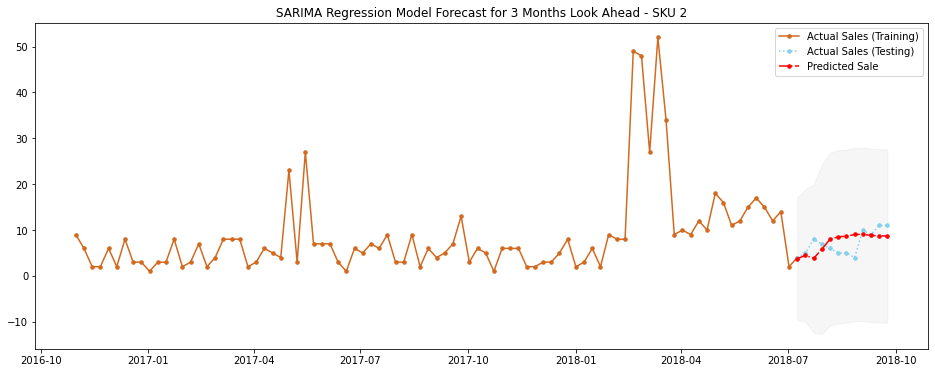

In [37]:
plot_sku(sku,2)

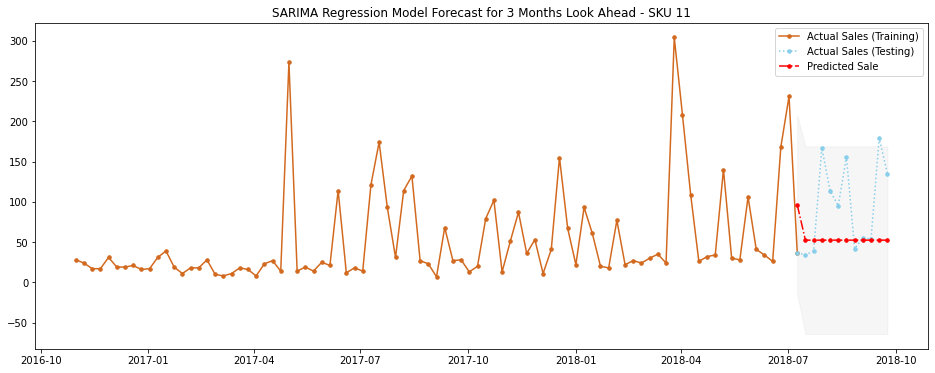

In [36]:
plot_sku(sku,11)

##4.2 Monitoring of Model Performance

In [31]:
def measure_metric(test_data, predict_ser,i):
  y = pd.DataFrame.to_numpy(test_data[i][:n_pred_period]).squeeze()
  yhat = pd.DataFrame.to_numpy(predict_ser[i]).squeeze()
  e = y-yhat
  mape=np.mean(e/y)*100
  return 'Mean Absolute Percentage Error: {:.2f} %'.format(mape)

In [32]:
measure_metric(test_data, predict_ser,11)

'Mean Absolute Percentage Error: 8.31 %'